## Bibliotecas e dados (MNIST)

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
tensorDados = False

In [3]:

if tensorDados:
    import tensorflow as tf
    (adults_handWrit,  adults_digit), (teens_handWrit, teens_digit) = tf.keras.datasets.mnist.load_data()
    print("O numero de numeros manuscritos feitos por adolescentes foi: \t ", "{:.2e}".format(len(teens_digit)) ) 
    print("O numero de numeros manuscritos feitos por adultos foi: \t ",   "{:.2e}".format(len(adults_digit)))
    handWrit = np.concatenate( ([x.flatten() for x in adults_handWrit] , [x.flatten() for x in teens_handWrit]) )
    handWrit = np.array( [ x/np.amax(x) for x in handWrit ] )
    digits   = np.concatenate( (adults_digit, teens_digit) )


## Importando dados de MS960

In [4]:
from scipy.io import loadmat
mat = loadmat("ex3data1.mat")
X = mat["X"]
Y = np.array(mat["y"])
n = len(X)
Y = [ Y.T[0][i] if Y.T[0][i] != 10 else 0 for i in range(n) ] 

## Parâmetros de inicialização

Para escolher o tamanho dos conjuntos de treino/teste.

In [5]:
p_treino = input("Insira o percentual do espaco amostral que deve ser usado para treino (numero entre zero e um).")
p_treino = float(p_treino)

if p_treino >= 1:
    p_treino = .9
if p_treino <= 0:
    p_treino = .1

p_teste = 1 - p_treino
    
print('O total de dados e ', n, '.')
print('Percentual para treino: ', 100* p_treino, '%.')
print('Percentual para teste:  ', 100* p_teste, '%.')

Insira o percentual do espaco amostral que deve ser usado para treino (numero entre zero e um)..8
O total de dados e  5000 .
Percentual para treino:  80.0 %.
Percentual para teste:   19.999999999999996 %.


## Tratamento de dados

In [6]:
class data:
    def __init__(self, x, y):
        self.entrada = x
        self.saida   = y

In [7]:
if tensorDados:
    dados = [data(handWrit[i], digits[i]) for i in range(len(digits))]
    np.random.shuffle( dados )
    treino = dados[: int( p_treino*n ) -2 ]
    teste  = dados[int( p_treino*n ) -1 : ] # vamos ter no minimo 1 dado para teste
    plt.imshow(treino[3].entrada.reshape(28, 28))
    print(treino[3].saida)

3


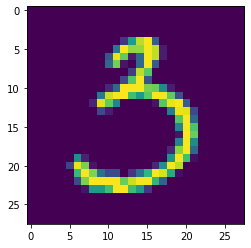

## Classe rede_neural

* **INICIALIZAÇÃO**: para inicializar a classe, é preciso fornecer:
    * os dados para o treino (que devem ser um objeto do tipo "data", definido acima);
    * a topologia da rede (um vetor em que cada elemento é o número de vetores por camada, sem considerar o bias);
    * constante para regularização (que deve ser zero caso não queira regularização).

In [ ]:
from scipy.special import expit as sig# sigmoid function
class rede_neural:  # Custo da Rede Neural com a composicao atual de pesos
    def __init__(self, data, topologia_rede, lambida_reg):
        self.dados = data
        self.num_exemplos = len(data)
        self.As = 0 # As # vamos guardar a solucao dos As aqui
        self.bs = 0 # bs # vamos guardar a solucao dos bs aqui
        self.dim_entrada = topologia_rede[1]
        self.dim_saida   = topologia_rede[-1]  # dimensao da saida da rede neural
        self.num_camadas = len(topologia_rede)
        self.topo = np.array(topologia_rede) # vetor que indica quantos neuronios por camada; incluindo os elementos da entrada e da saida
        self.num_vars = np.sum( [self.topo[i] * self.topo[i+1] + self.topo[i+1] for i in range(len(self.topo)-1)] )  # estamos calculando qual o num total de variaveis; soma dos elementos das matrizes A e vetores b
        self.pesos_iniciais = ( np.random.rand(self.num_vars)  -  1/2 ) 
        #self.neuronios = [] # valor de cada neuronio (ativacao); vetor de vetores; o tamanho de cada vetor e dado pela topologia
        self.deltas = []  # erro de cada neuronio; msm arquitetura dos neuronios (cada neuronio tem um delta)
        self.J = []  # pra armazenar o custo e ver a curva de aprendizado por iteracao; tempo para aprender. outra curva interessante eh a de custo por num de exemplos (lembrando que dependendo das condicoes iniciais e do conjunto de exepplos dados podemos observar curvas diferentes msm se o num de exemplos for igual)
        self.DJ = np.zeros(self.num_vars)  # gradiente de J em funcao dos pesos; tem a msm dimensao de self.pesos_iniciais
        self.cont_teste = 0
        self.num_it = 0
        self.regularizacao = False
        self.lambida = lambida_reg
        
    def sol(self, teste): # dado um vetor imagem retorna a saida da rede neural
        x = teste
        for A, b in zip(self.As, self.bs):
            x = sig( x@A + b ) 
        return x
        
    # Embrulha e desembrulha sao necessarias pois a funcao scipy.optimize.minimize requer um vetor
    def embrulha(self, x): # dado um vetor de variaveis (os pesos da rede) monta as matrizes A e b da rede neural
        x = np.array(x) # x = pesos da rede neural
        As = []
        bs = []
        cont = 0
        for i in range(self.num_camadas - 1):
            m = self.topo[i]
            n = self.topo[i+1]
            p = m*n
            As.append(x[cont:cont+p].reshape(m, n))
            cont += p
            bs.append(x[cont:cont+n])
            cont += n
        return [As, bs]
        
    def desembrulha(self, As, bs): # dadas as matrizes As e bs da rede neural, retorna um vetor com os pesos
        x = []
        for A, b in zip(As, bs):
            x.extend(A.flatten())
            x.extend(b)
        return np.array(x)
    
    
    
    def cost_fun(self, pesos):
        self.num_it += 1
        self.pesos_iniciais = pesos # para nao perder o progresso se por acaso for interrompido pela metade; para ver a evolucao a cada iteracao;
        custo = 0 # zerando o custo 
        self.DJ = np.zeros(self.num_vars) # zerando o grad
        Abs = self.embrulha(pesos)
        As = Abs[0]
        bs = Abs[1]
        
        if self.lambida != 0:
            self.regularizacao = True
            
        if self.regularizacao:
            # o sinal é negativo pq o log ali em cima deixa negativo, mas la no final a gente retorna o negativo do custo
            custo -= self.lambida * np.square( self.desembrulha(As, [np.zeros(bs[l].shape) for l in range(len(bs)) ] ) ).sum() / (2*self.num_exemplos)
         
        
        for d in self.dados:  # neuronios nao precisa ser global da classe, pq muda pra cada exemplo (a menos que vc queira guardar todos os neuronios de todos os exemplos, teria alguma vantagem na velocidade de execucao?). arrumar isso dps
            res = np.zeros(self.dim_saida)
            res[d.saida] = 1
            x = d.entrada

            neuronios = []     # precisamos zerar para carregar novos exemplos
            neurocamada = [1]
            neurocamada.extend(x) # o 1 eh pq agr vamos usar a notacao de aula (matriz THETA, que junto A e b)
            neuronios.append(np.array(neurocamada))
            
            for A, b in zip(As, bs):
                x = sig( x@A + b ) 
                neurocamada = [1]
                neurocamada.extend(x) 
                neuronios.append(np.array(neurocamada))

            custo += (res*np.log(x)).sum() + ((1-res)*np.log(1-x)).sum()
                   
            #custo += ( (res - x)**2 ).sum() # custo de minimos quadrados; nao funcionou bem
            
            # daqui em diante é p/ calc. o grad da cost_fun
            neuronios[-1] = np.delete(neuronios[-1], 0) # estamos tirando o neuronio bias da ultima camada (pq nao existe na ultima)
            
            # A linha seguinte foi excluida pq ele foi feita em um contexto que eu precisava guardar simultaneamente o valor de todos os neuronios, visto que a funcao minimize espera duas funcoes diferentes para cost e para grad do cost; para resolver isso eu calculei tudo na cost e guardei o valor do grad globalmente na classe; preciso ver a ordem que a minimize chama as coisas para ver se funciona;
            #d.neuronios.append(neuronios) # adicionamos a ultima camada de ativacao no vetor de neuronios do exemplo d
            
            delta = [None]*(self.num_camadas) # o primeiro fica vazio pois a entrada nao tem erro
            delta[-1] = neuronios[-1] - res # pulamos a primeira posicao dos neuronios pq ela representa o bias, que nao tem conexao com a camada anterior (agora estamos usando a notacao da aula ao inves da nossa notacao xA+b; para obter a matriz theta basta fazer np.vstack(b, A).T)
            for i in range( (self.num_camadas-1) - 1, 0, -1 ): 
                delta[i] = (delta[i+1]@As[i].T) * neuronios[i][1:] * (1 - neuronios[i][1:])
            #print(len(neuronios), 'num de camadas com neuronios;', "neuronios: ", neuronios)
            
            DJtheta = [] # vamos append todas as matrizes theta aqui
            for i in range(self.num_camadas-1):
                DJtheta.append( np.vstack(  (np.zeros(bs[i].shape), np.zeros(As[i].shape)) ).T ) # arquitetura das derivadas parciais de J na notacao de THETA vista em aula
            teste_num_pesos = 0
            for l in range(self.num_camadas-1):
                for i in range(self.topo[l+1]):
                    for j in range(0, self.topo[l]+1): # +1 pq nessa notacao contabilizamos o bias na matriz theta
                        teste_num_pesos += 1
                        DJtheta[l][i,j] = neuronios[l][j] * delta[l+1][i]  
                        if self.regularizacao and j != 0: # j == 0 é o bias ne?
                            DJtheta[l][i,j] += self.lambida*As[l][j-1, i]/self.num_exemplos  # conferir se eu to pegando a aresta (peso) certa
                            
            #print(teste_num_pesos)
            theta_to_As = []
            theta_to_bs = []
            Abstheta = [  [ theta_to_As.append(DJtheta[i].T[ np.arange(self.topo[i] )+ 1 ]), theta_to_bs.append(DJtheta[i].T[[0]][0]) ] for i in range(self.num_camadas-1) ]
            #print(Abstheta, theta_to_As, theta_to_bs)
            
            # Somando o grad do i-esimo exemplo ao grad total
            self.DJ += self.desembrulha( theta_to_As, theta_to_bs ) / self.num_exemplos
            
        self.cont_teste += 1
        print(self.cont_teste, -custo/self.num_exemplos)
        
        self.J.append(-custo/self.num_exemplos)
        return -custo/self.num_exemplos, self.DJ
    
    # Acabou nao precisando pq a funcao scipy.optimize.minimize aceita que a funcao objetivo retorne o gradiente junto, basta fazer jac = True
    def grad_cost_fun(self, pesos):
        if (self.pesos_iniciais == pesos).all():
            return self.DJ
        else:
            print("Gradiente atrasado (o mesmo da iteracao anterior).")
            return self.DJ
    
    
    
    
    def grad_desc(self, theta, alpha, max_iter, Lambda):
        
        J_history = []
        
        for i in range(max_iter):
            cost, DJ = self.cost_fun_reg(theta, Lambda)
            if((i!=0) and (abs(cost)>abs(J_history[-1]))):
                # Tem um jeito mais elegante? Tentei fazer i = max_iter, mas n rolou, nem i = max_iter-1
                return theta, J_history
            else:
                theta = theta - (alpha * DJ)
                J_history.append(cost)
            
        
        return theta, J_history
    
    

## Importando os dados da aula (MS960)

In [9]:
from scipy.io import loadmat
mat = loadmat("ex3data1.mat")
X = mat["X"]
Y = np.array(mat["y"])
n = len(X)
Y = [ Y.T[0][i] if Y.T[0][i] != 10 else 0 for i in range(n) ] 

## Tratando os dados

5


1001

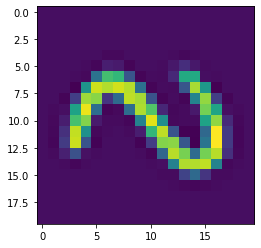

In [10]:

dados_MS960 = [data(X[i], Y[i]) for i in range(len(X))]
np.random.shuffle( dados_MS960 )
treino = dados_MS960[: int( p_treino*n ) -2 ]
teste  = dados_MS960[int( p_treino*n ) -1 : ] # vamos ter no minimo 1 dado para teste
plt.imshow(treino[0].entrada.reshape(20, 20))
print(treino[0].saida)
len(teste)

## Inicializando a rede neural

In [27]:
helpme = rede_neural(treino, [400, 25, 10], 0)
len(treino)
#helpme.num_vars

3998

In [130]:
from scipy.optimize import minimize
options = {'maxiter':20}
#sol = minimize(helpme.cost_fun, helpme.pesos_iniciais, options=options)
sol = minimize(helpme.cost_fun, helpme.pesos_iniciais, jac = helpme.grad_cost_fun, options=options)

217 0.09209316087773922
218 0.09179315251390978
219 0.0912556325465578
220 0.09047062040818397
221 0.09012010961769494
222 0.08990909871515278
223 0.08953960081668273
224 0.0889453782868112
225 0.08830015033371787
226 0.08794448212525727
227 0.08738306311233576
228 0.08670593144526166
229 0.08625331846995385
230 0.08578079829292419
231 0.08541975639768702
232 0.08498915104058906
233 0.08448082978010273
234 0.08399816447392106
235 0.08365404676341237
236 0.08336423191890878
237 0.08300275662608117


In [253]:
helpme.num_it = 0
pesos = helpme.pesos_iniciais

In [171]:
helpme.As = helpme.embrulha(sol['x'])[0]
helpme.bs = helpme.embrulha(sol['x'])[1]

In [14]:

    
def performance_rede(rede_neural, espaco_amostral_para_teste):
    espaco = espaco_amostral_para_teste
    rede = rede_neural
    cont_acertos = 0
    erros = np.zeros(10)
    cont_alg = np.zeros(10)
    for k in range(len(espaco)):
        x = espaco[k].entrada
        for A, b in zip(rede.As, rede.bs):
            x = sig( x@A + b ) 
        if np.argmax(x) == espaco[k].saida:
            cont_acertos +=1
        else:
            erros[espaco[k].saida] += 1
        cont_alg[espaco[k].saida] += 1
        
    distrib_por_alg_no_espaco = 100*cont_alg/len(espaco)
    taxa_acerto = cont_acertos/len(espaco)*100
    erro_por_algarismo = erros/cont_alg*100
    print("percentual de acerto: ", taxa_acerto)
    print("percentual de erro de cada algarismo: ", erro_por_algarismo)
    print("distribuicao de cada algarismo no espaço: ", distrib_por_alg_no_espaco)
    return taxa_acerto, erro_por_algarismo, distrib_por_alg_no_espaco
    
#performance_rede(helpme, teste)

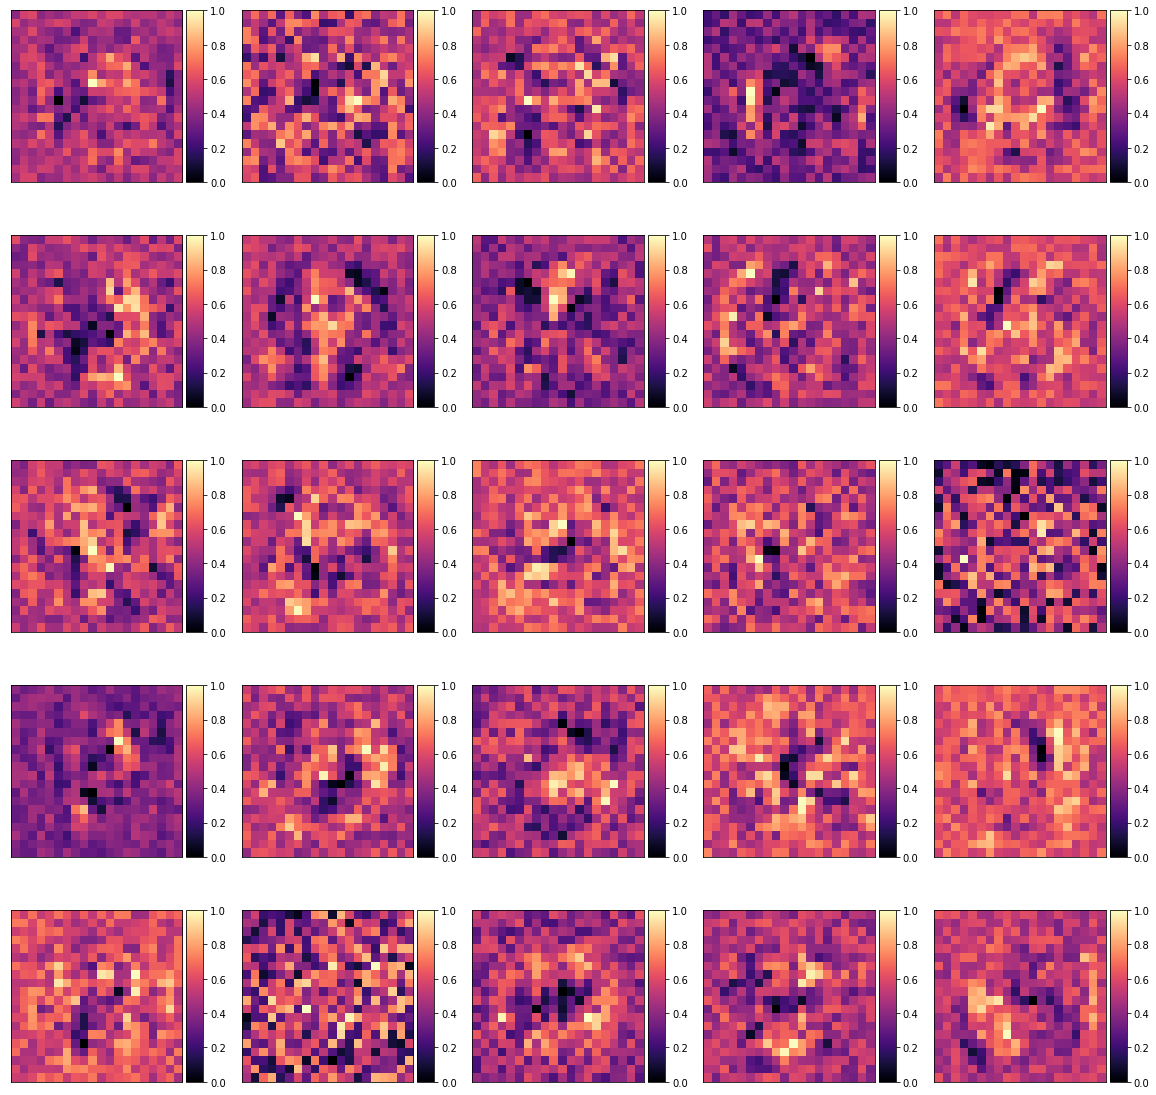

In [175]:

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator

fig, axs = plt.subplots( 5, 5, figsize = (20, 20))  # para representar a ativacao dos 25 neuronios da camada escondida em funcao da img de entrada
neuros_camada_escondida = np.arange(25)
for (i, img_ativacao) in enumerate(helpme.As[0].T[neuros_camada_escondida]):
    img_ativacao = (img_ativacao - np.min(img_ativacao) ) / (np.max(img_ativacao) - np.min(img_ativacao))  # scaling os pesos
    im = axs[int(i/5)][i%5].imshow(img_ativacao.reshape(20, 20), cmap = 'magma')
    im.axes.get_xaxis().set_visible(False)
    im.axes.get_yaxis().set_visible(False)
    # Create divider for existing axes instance
    divider = make_axes_locatable(axs[int(i/5)][i%5])
    # Append axes to the right of ax, with 10% width of ax
    cax = divider.append_axes("right", size="10%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax, ticks=MultipleLocator(0.2), format="%.1f")
plt.savefig("camada_escondida.png")
plt.show()


In [11]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## Curva de aprendizado (percentual de acerto vs num. de exemplos de treino)
tempo estimado para rodar: 32 horas

In [ ]:
n_ex_treino = [19, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000] #, 2400, 2800, 3200, 3600, 4000]
curva_aprendizado = []
curva_aprendizado_sobre_estudo = []
curva_aprendizado_sobre_prova = []
plt.figure(figsize=(12,9))
for (i, num_treino) in enumerate(n_ex_treino):
    print(i, num_treino)
    estudo = dados_MS960[: int( num_treino ) -2 ]
    prova  = dados_MS960[int( num_treino ) -1 : ] # vamos ter no minimo 1 dado para teste
    print("O numero de exemplos para treino é ", len(estudo),".")
    print("O numero de exemplos para teste é ", len(prova),".")
    guigo = rede_neural(estudo, [400, 25, 10], 0)
    guigo_configs = {'maxiter': 25 } # depois aumentar para 500 
    sol_guigo = minimize(guigo.cost_fun, guigo.pesos_iniciais, jac = True,options=guigo_configs)
    guigo.As = guigo.embrulha(sol_guigo['x'])[0]
    guigo.bs = guigo.embrulha(sol_guigo['x'])[1]
    curva_aprendizado.append(performance_rede(guigo, estudo))
    curva_aprendizado.append(performance_rede(guigo, prova))
    curva_aprendizado_sobre_estudo.append(performance_rede(guigo, estudo)[0])
    curva_aprendizado_sobre_prova.append(performance_rede(guigo, prova)[0])
plt.plot(n_ex_treino, curva_aprendizado_sobre_estudo)
plt.plot(n_ex_treino, curva_aprendizado_sobre_prova)
plt.show()

In [44]:
print(curva_aprendizado_sobre_estudo, curva_aprendizado_sobre_prova)

[100.0, 100.0, 99.4949494949495, 99.66442953020133, 100.0, 99.19678714859438, 99.1638795986622, 98.8538681948424, 98.99749373433583, 98.21826280623608] [42.45283018867924, 61.273209549071616, 75.33847115184336, 79.64262922782387, 82.78635079330581, 83.31481892912687, 85.95773687798227, 86.07300627760985, 87.36015234467985, 86.80809558644233]


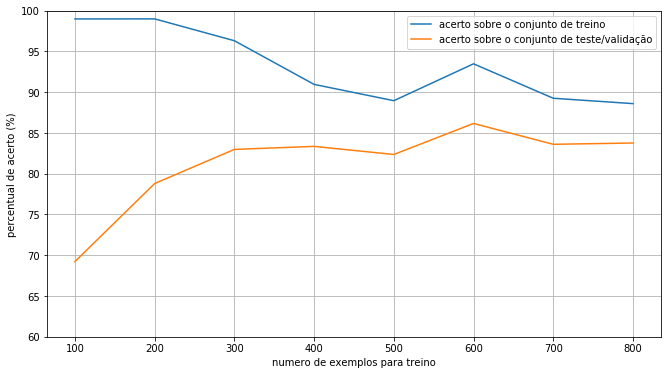

In [32]:
plt.figure(figsize=(11,6))
plt.plot(n_ex_treino[:8], curva_aprendizado_sobre_estudo, label = 'acerto sobre o conjunto de treino')
plt.plot(n_ex_treino[:8], curva_aprendizado_sobre_prova, label = 'acerto sobre o conjunto de teste/validação')
plt.xlabel('numero de exemplos para treino')
plt.ylabel('percentual de acerto (%)')
plt.ylim(60, 100)
plt.grid()
plt.legend()
plt.savefig('aprendizado.png')
plt.show()

In [29]:
print(curva_aprendizado_sobre_estudo, curva_aprendizado_sobre_prova)

[98.9795918367347, 98.98989898989899, 96.30872483221476, 90.95477386934674, 88.95582329317268, 93.47826086956522, 89.25501432664757, 88.59649122807018] [69.23076923076923, 78.7960841491356, 82.98234418208892, 83.35144533797, 82.35947567207288, 86.1622358554874, 83.60846314810509, 83.76577005474887]


In [146]:
guigo = rede_neural(estudo, [400, 25, 10], 0)
guigo_configs = {'maxiter':20} # depois aumentar para 500 
sol_guigo = minimize(guigo.cost_fun, guigo.pesos_iniciais, jac = guigo.grad_cost_fun, options=guigo_configs)

1 8.183596998263091


In [147]:
print( curva_aprendizado_sobre_estudo, curva_aprendizado_sobre_prova)

[5.1020408163265305, 14.646464646464647, 9.296482412060302, 16.666666666666664, 4.841402337228715] [9.385839624566415, 12.72651530931056, 10.106498587263639, 15.020233277791, 4.288345172323073]


In [152]:
plt.show()

In [164]:
sol_guigo

      fun: 6.92147174579028
 hess_inv: array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])
      jac: array([0., 0., 0., ..., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 1
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([ 0.33286259,  0.03254887, -0.31956272, ..., -0.3772649 ,
        0.11509971, -0.11499625])

## Testes e solucao sem usar back propagation (gradiente calculado numericamente)

In [98]:
minha_rede = rede_neural(treino, [400, 25, 10])
len(treino)

3998

In [201]:
from scipy.optimize import minimize
options = {'maxiter':5}
sol = minimize(minha_rede.cost_fun, minha_rede.pesos_iniciais, options=options)

164814 1.544215982036284
164815 1.544215982036284
164816 1.544215982036284
164817 1.544215982036284
164818 1.544215982036284
164819 1.544215982036284
164820 1.544215982036284
164821 1.544215982036284
164822 1.544215982036284
164823 1.544215982036284
164824 1.544215982036284
164825 1.544215982036284
164826 1.544215982036284
164827 1.544215982036284
164828 1.544215982036284
164829 1.544215982036284
164830 1.544215982036284
164831 1.544215982036284
164832 1.544215982036284
164833 1.544215982036284
164834 1.544215982036284
164835 1.544215982036284
164836 1.544215982036284
164837 1.544215982036284
164838 1.544215982036284
164839 1.544215982036284
164840 1.544215982036284
164841 1.544215982036284
164842 1.544215982036284
164843 1.544215982036284
164844 1.544215982036284
164845 1.544215982036284
164846 1.544215982036284
164847 1.544215982036284
164848 1.544215982036284
164849 1.544215982036284
164850 1.544215982036284
164851 1.544215982036284
164852 1.544215982036284
164853 1.544215982036284


KeyboardInterrupt: 

In [55]:
vec = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16 ,17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
rede_teste = rede_neural(treino, [4, 4, 2])

rede_teste.embrulha(vec)

[[array([[ 1,  2,  3,  4],
         [ 5,  6,  7,  8],
         [ 9, 10, 11, 12],
         [13, 14, 15, 16]]), array([[21, 22],
         [23, 24],
         [25, 26],
         [27, 28]])], [array([17, 18, 19, 20]), array([29, 30])]]

In [16]:
sol

      fun: -8.999976721445773
 hess_inv: array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])
      jac: array([0., 0., 0., ..., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 162554
      nit: 14
     njev: 17
   status: 0
  success: True
        x: array([-0.06877965, -0.38610829,  0.2628554 , ...,  0.14656719,
        0.10768387,  0.08042761])

In [102]:
minha_rede.As = minha_rede.embrulha(sol['x'])[0]
minha_rede.bs = minha_rede.embrulha(sol['x'])[1]

In [119]:
cont = 0
erros = np.zeros(10)
cont_alg = np.zeros(10)
for k in range(len(teste)):
    x = teste[k].entrada
    for A, b in zip(minha_rede.As, minha_rede.bs):
        x = sig( x@A + b ) 
    if np.argmax(x) == teste[k].saida:
        cont +=1
    else:
        erros[teste[k].saida] += 1
    cont_alg[teste[k].saida] += 1

print("percentual de acerto: ", cont/len(teste))
print("percentual de erro de cada algarismo: ", erros/cont_alg*100)

percentual de acerto:  0.7092907092907093
percentual de erro de cada algarismo:  [10.22727273  5.76923077 65.38461538 16.84210526 22.44897959 46.22641509
 31.63265306 11.70212766 23.80952381 49.5412844 ]


3498

In [131]:
print([1].extend(lista))

None


In [136]:
lista = [1, 2, 3]
um = [1]
print(um.extend(lista))
print(um)
print(lista)

None
[1, 1, 2, 3]
[1, 2, 3]


In [137]:
l = []
l.extend(lista)
print(l)

[1, 2, 3]


In [139]:
arr = np.array([1, 2, 2, 2, ])
l.extend(arr)
print(type(l))

<class 'list'>


In [159]:
np.array([1, 2, 3]) == np.array([1, 2, 3])

array([ True,  True,  True])

In [64]:
tetas = []
rede_dupla = rede_neural(dados_MS960[:4000], [400, 25, 25, 10], 0)
tetas.append(rede_dupla.pesos_iniciais)
for i in range(100):
    configs = {'maxiter':1} # depois aumentar para 500 
    sol_dupla = minimize(rede_dupla.cost_fun, rede_dupla.pesos_iniciais, jac = True, options=configs)
    tetas.append(sol_dupla['x'])
    print(tetas)

1 7.066196328801284
2 7.066196328801284
3 4.260744198950384
[array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.17688825,
       -0.08413913, -0.21524412]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.23349269,
       -0.14805201, -0.32091014])]


KeyboardInterrupt: 

In [65]:
it = [1, 2]
for i in range(100):
    it.append(it[i+1]+1+int(i/4))
    configs = {'maxiter':1+int(i/4)} # depois aumentar para 500 
    sol_dupla = minimize(rede_dupla.cost_fun, rede_dupla.pesos_iniciais, jac = True, options=configs)
    tetas.append(sol_dupla['x'])
    print(tetas)

4 4.260744198950384
5 4.260744198950384
6 3.3105872735714317
[array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.17688825,
       -0.08413913, -0.21524412]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.23349269,
       -0.14805201, -0.32091014]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.29918063,
       -0.22639993, -0.41989801])]
7 3.3105872735714317
8 3.3105872735714317
9 3.269312434545902
[array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.17688825,
       -0.08413913, -0.21524412]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.23349269,
       -0.14805201, -0.32091014]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.29918063,
       -0.22639993, -0.41989801]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32654548,
       -0.25726687, -0.44261051])]
10 3.269312434545902
11 3.269312434545902
12 3.2621681655803414
13 3.2378502720718285
[array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.17688825,
       -0.08413913, -0.21524412

47 2.0008253019792317
48 2.0008253019792317
49 1.9416398216022124
50 1.9194791949028671
51 1.88557491390593
[array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.17688825,
       -0.08413913, -0.21524412]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.23349269,
       -0.14805201, -0.32091014]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.29918063,
       -0.22639993, -0.41989801]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32654548,
       -0.25726687, -0.44261051]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.3299442 ,
       -0.2557832 , -0.43220377]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32832374,
       -0.26521888, -0.44164813]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32738808,
       -0.33957124, -0.44905698]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.35783771,
       -0.34955298, -0.4473608 ]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.36692646,
       -0.35393311, -0.46277855]), 

81 1.2780663572893902
82 1.2780663572893902
83 1.2522460393539259
84 1.234120287692204
85 1.2196163678680507
86 1.1927396645833865
87 1.1430784681927366
[array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.17688825,
       -0.08413913, -0.21524412]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.23349269,
       -0.14805201, -0.32091014]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.29918063,
       -0.22639993, -0.41989801]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32654548,
       -0.25726687, -0.44261051]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.3299442 ,
       -0.2557832 , -0.43220377]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32832374,
       -0.26521888, -0.44164813]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32738808,
       -0.33957124, -0.44905698]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.35783771,
       -0.34955298, -0.4473608 ]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.

109 0.8877096391541799
110 0.8877096391541799
111 0.8771251953115391
112 0.8638465810743932
113 0.858346795299368
114 0.848249846247538
115 0.8294923905612728
116 0.7951838296328017
[array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.17688825,
       -0.08413913, -0.21524412]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.23349269,
       -0.14805201, -0.32091014]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.29918063,
       -0.22639993, -0.41989801]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32654548,
       -0.25726687, -0.44261051]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.3299442 ,
       -0.2557832 , -0.43220377]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32832374,
       -0.26521888, -0.44164813]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32738808,
       -0.33957124, -0.44905698]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.35783771,
       -0.34955298, -0.4473608 ]), array([ 0.2772793 , -0.14

141 0.6186054165131473
142 0.6186054165131473
143 0.6112348385529083
144 0.6057043127283028
145 0.6005541129077482
146 0.5977589070665075
147 0.5927616643803963
148 0.5836828934497431
149 0.5673579798749472
[array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.17688825,
       -0.08413913, -0.21524412]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.23349269,
       -0.14805201, -0.32091014]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.29918063,
       -0.22639993, -0.41989801]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32654548,
       -0.25726687, -0.44261051]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.3299442 ,
       -0.2557832 , -0.43220377]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32832374,
       -0.26521888, -0.44164813]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32738808,
       -0.33957124, -0.44905698]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.35783771,
       -0.34955298, -0.4473608 ]), 

168 0.486289870290804
169 0.486289870290804
170 0.48157497104054225
171 0.47478550464014413
172 0.47034640660525023
173 0.46667657088737935
174 0.46328845146369046
175 0.46048594959888756
176 0.45599373124816417
[array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.17688825,
       -0.08413913, -0.21524412]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.23349269,
       -0.14805201, -0.32091014]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.29918063,
       -0.22639993, -0.41989801]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32654548,
       -0.25726687, -0.44261051]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.3299442 ,
       -0.2557832 , -0.43220377]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32832374,
       -0.26521888, -0.44164813]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32738808,
       -0.33957124, -0.44905698]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.35783771,
       -0.34955298, -0.4473608

197 0.38720074910893015
198 0.38720074910893015
199 0.38452143381737636
200 0.38173585230554336
201 0.380488692150831
202 0.3782565691556547
203 0.3745412656121666
204 0.3695760756751084
205 0.36642708630696397
206 0.3608922541975516
[array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.17688825,
       -0.08413913, -0.21524412]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.23349269,
       -0.14805201, -0.32091014]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.29918063,
       -0.22639993, -0.41989801]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32654548,
       -0.25726687, -0.44261051]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.3299442 ,
       -0.2557832 , -0.43220377]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32832374,
       -0.26521888, -0.44164813]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32738808,
       -0.33957124, -0.44905698]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.35783771,
       -

228 0.3044530323371328
229 0.3044530323371328
230 0.3018472128792685
231 0.2976096052604574
232 0.2935913566714118
233 0.29226892368676705
234 0.29037902487931705
235 0.2891782213385002
236 0.28765543856352116
237 0.2849530000711387
238 0.28006826992083383
[array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.17688825,
       -0.08413913, -0.21524412]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.23349269,
       -0.14805201, -0.32091014]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.29918063,
       -0.22639993, -0.41989801]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32654548,
       -0.25726687, -0.44261051]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.3299442 ,
       -0.2557832 , -0.43220377]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32832374,
       -0.26521888, -0.44164813]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32738808,
       -0.33957124, -0.44905698]), array([ 0.2772793 , -0.14410654,  0.07678923, ...

261 0.24056863088934197
262 0.24056863088934197
263 0.23829135382796232
264 0.23627764595834488
265 0.2356809810848913
266 0.2345832277601352
267 0.23267587957914654
268 0.22997650361669453
269 0.2285673878969871
270 0.22699950570816937
271 0.2242651411241468
272 0.21940752620215234
[array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.17688825,
       -0.08413913, -0.21524412]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.23349269,
       -0.14805201, -0.32091014]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.29918063,
       -0.22639993, -0.41989801]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32654548,
       -0.25726687, -0.44261051]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.3299442 ,
       -0.2557832 , -0.43220377]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32832374,
       -0.26521888, -0.44164813]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32738808,
       -0.33957124, -0.44905698]), array([ 0.2772793 , -0

285 0.1987485835934685
286 0.1987485835934685
287 0.1966688896406954
288 0.19507408018463643
289 0.1947333269517824
290 0.1940850625596072
291 0.19287620011989826
292 0.19076142081269076
293 0.18772513566513024
294 0.18600525950372615
295 0.1841040209877879
296 0.18081792102073296
[array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.17688825,
       -0.08413913, -0.21524412]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.23349269,
       -0.14805201, -0.32091014]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.29918063,
       -0.22639993, -0.41989801]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32654548,
       -0.25726687, -0.44261051]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.3299442 ,
       -0.2557832 , -0.43220377]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32832374,
       -0.26521888, -0.44164813]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32738808,
       -0.33957124, -0.44905698]), array([ 0.2772793 , -0.1

309 0.16218452536674083
310 0.16218452536674083
311 0.1612102719890997
312 0.15978709970743338
313 0.1589608847995085
314 0.15826434462256747
315 0.15719180488843446
316 0.15609543511401838
317 0.15531791002587556
318 0.15410470002280438
319 0.15217738759302524
320 0.14912349996624402
321 0.14464915027729305
[array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.17688825,
       -0.08413913, -0.21524412]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.23349269,
       -0.14805201, -0.32091014]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.29918063,
       -0.22639993, -0.41989801]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32654548,
       -0.25726687, -0.44261051]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.3299442 ,
       -0.2557832 , -0.43220377]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32832374,
       -0.26521888, -0.44164813]), array([ 0.2772793 , -0.14410654,  0.07678923, ..., -0.32738808,
       -0.33957124, -0.44905698

335 0.12974228897641643
336 0.12974228897641643
337 0.12924809029278872
338 0.1283875091059317


KeyboardInterrupt: 

percentual de acerto:  10.2
percentual de erro de cada algarismo:  [100. 100. 100. 100. 100.   0. 100. 100. 100. 100.]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  9.950000000000001
percentual de erro de cada algarismo:  [100. 100. 100. 100. 100.   0. 100. 100. 100. 100.]
distribuicao de cada algarismo no espaço:  [ 9.925 10.125  9.95   9.925 10.175  9.95  10.275  9.75   9.725 10.2  ]
percentual de acerto:  10.2
percentual de erro de cada algarismo:  [100. 100. 100. 100. 100.   0. 100. 100. 100. 100.]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  10.2
percentual de erro de cada algarismo:  [100. 100. 100. 100. 100.   0. 100. 100. 100. 100.]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  10.2
percentual de erro de cada algarismo:  [100. 100. 100. 100. 100.   0. 100. 100. 100

percentual de acerto:  9.175
percentual de erro de cada algarismo:  [99.74811083 99.50617284 98.99497487 86.39798489 93.36609337 91.45728643
 49.8783455  96.41025641 95.11568123 98.52941176]
distribuicao de cada algarismo no espaço:  [ 9.925 10.125  9.95   9.925 10.175  9.95  10.275  9.75   9.725 10.2  ]
percentual de acerto:  6.4
percentual de erro de cada algarismo:  [100.         100.         100.          88.34951456  95.69892473
  93.1372549   65.16853933  96.36363636  97.2972973   96.73913043]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  6.4
percentual de erro de cada algarismo:  [100.         100.         100.          88.34951456  95.69892473
  93.1372549   65.16853933  96.36363636  97.2972973   96.73913043]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  6.4
percentual de erro de cada algarismo:  [100.         100.         100.         

percentual de acerto:  13.5
percentual de erro de cada algarismo:  [100.          95.78947368 100.          60.19417476  68.8172043
  99.01960784  51.68539326  95.45454545  92.79279279  95.65217391]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  13.5
percentual de erro de cada algarismo:  [100.          95.78947368 100.          60.19417476  68.8172043
  99.01960784  51.68539326  95.45454545  92.79279279  95.65217391]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  13.5
percentual de erro de cada algarismo:  [100.          95.78947368 100.          60.19417476  68.8172043
  99.01960784  51.68539326  95.45454545  92.79279279  95.65217391]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  13.5
percentual de erro de cada algarismo:  [100.          95.78947368 100.          60.1941747

percentual de acerto:  58.8
percentual de erro de cada algarismo:  [26.44836272  9.13580247 52.7638191  11.83879093 30.95823096 82.66331658
 13.13868613 22.05128205 75.83547558 87.99019608]
distribuicao de cada algarismo no espaço:  [ 9.925 10.125  9.95   9.925 10.175  9.95  10.275  9.75   9.725 10.2  ]
percentual de acerto:  60.3
percentual de erro de cada algarismo:  [19.41747573  4.21052632 55.88235294 16.50485437 19.35483871 87.25490196
 22.47191011 18.18181818 71.17117117 79.34782609]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  60.3
percentual de erro de cada algarismo:  [19.41747573  4.21052632 55.88235294 16.50485437 19.35483871 87.25490196
 22.47191011 18.18181818 71.17117117 79.34782609]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  60.3
percentual de erro de cada algarismo:  [19.41747573  4.21052632 55.88235294 16.50485437 19.354838

percentual de acerto:  67.2
percentual de erro de cada algarismo:  [ 3.88349515  1.05263158 27.45098039 38.83495146 39.78494624 93.1372549
 26.96629213 36.36363636 36.03603604 20.65217391]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  69.075
percentual de erro de cada algarismo:  [ 4.53400504  3.20987654 26.13065327 35.76826196 51.10565111 85.42713568
 17.51824818 32.82051282 35.98971722 17.64705882]
distribuicao de cada algarismo no espaço:  [ 9.925 10.125  9.95   9.925 10.175  9.95  10.275  9.75   9.725 10.2  ]
percentual de acerto:  67.2
percentual de erro de cada algarismo:  [ 3.88349515  1.05263158 27.45098039 38.83495146 39.78494624 93.1372549
 26.96629213 36.36363636 36.03603604 20.65217391]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  67.2
percentual de erro de cada algarismo:  [ 3.88349515  1.05263158 27.45098039 38.83495146 39.784946

percentual de acerto:  74.5
percentual de erro de cada algarismo:  [10.67961165  1.05263158 33.33333333 18.44660194  7.52688172 41.17647059
  6.74157303 14.54545455 35.13513514 86.95652174]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  74.5
percentual de erro de cada algarismo:  [10.67961165  1.05263158 33.33333333 18.44660194  7.52688172 41.17647059
  6.74157303 14.54545455 35.13513514 86.95652174]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  74.5
percentual de erro de cada algarismo:  [10.67961165  1.05263158 33.33333333 18.44660194  7.52688172 41.17647059
  6.74157303 14.54545455 35.13513514 86.95652174]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  74.5
percentual de erro de cada algarismo:  [10.67961165  1.05263158 33.33333333 18.44660194  7.52688172 41.17647059
  6.7

percentual de acerto:  83.0
percentual de erro de cada algarismo:  [ 3.88349515  0.         15.68627451 27.18446602 15.05376344 29.41176471
 11.23595506 20.         20.72072072 25.        ]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  83.0
percentual de erro de cada algarismo:  [ 3.88349515  0.         15.68627451 27.18446602 15.05376344 29.41176471
 11.23595506 20.         20.72072072 25.        ]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  83.0
percentual de erro de cada algarismo:  [ 3.88349515  0.         15.68627451 27.18446602 15.05376344 29.41176471
 11.23595506 20.         20.72072072 25.        ]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  83.0
percentual de erro de cada algarismo:  [ 3.88349515  0.         15.68627451 27.18446602 15.05376344 29.41176471
 11.2

percentual de acerto:  87.02499999999999
percentual de erro de cada algarismo:  [ 4.53400504  3.20987654 17.5879397  11.33501259 16.21621622 24.62311558
  3.89294404  8.97435897 12.59640103 26.71568627]
distribuicao de cada algarismo no espaço:  [ 9.925 10.125  9.95   9.925 10.175  9.95  10.275  9.75   9.725 10.2  ]
percentual de acerto:  85.7
percentual de erro de cada algarismo:  [ 5.82524272  1.05263158 21.56862745 17.47572816 11.82795699 21.56862745
  4.49438202 12.72727273 15.31531532 30.43478261]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  85.7
percentual de erro de cada algarismo:  [ 5.82524272  1.05263158 21.56862745 17.47572816 11.82795699 21.56862745
  4.49438202 12.72727273 15.31531532 30.43478261]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  85.7
percentual de erro de cada algarismo:  [ 5.82524272  1.05263158 21.56862745 17.47572

percentual de acerto:  90.325
percentual de erro de cada algarismo:  [ 3.02267003  3.45679012 11.05527638 12.59445844 11.54791155 14.8241206
  6.08272506 10.25641026 12.59640103 11.51960784]
distribuicao de cada algarismo no espaço:  [ 9.925 10.125  9.95   9.925 10.175  9.95  10.275  9.75   9.725 10.2  ]
percentual de acerto:  89.5
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158 10.78431373 18.44660194  7.52688172 14.70588235
  4.49438202 12.72727273 12.61261261 16.30434783]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  89.5
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158 10.78431373 18.44660194  7.52688172 14.70588235
  4.49438202 12.72727273 12.61261261 16.30434783]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  89.5
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158 10.78431373 18.44660194  7.52688

percentual de acerto:  89.3
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158 11.76470588 19.41747573  6.4516129  14.70588235
  4.49438202 14.54545455 12.61261261 15.2173913 ]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  90.2
percentual de erro de cada algarismo:  [ 4.85436893  0.         12.74509804 15.53398058  7.52688172 18.62745098
  3.37078652  7.27272727 12.61261261 14.13043478]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  92.225
percentual de erro de cada algarismo:  [ 1.76322418  2.4691358  13.5678392   8.0604534   8.10810811 14.32160804
  3.89294404  7.17948718  9.25449871  9.31372549]
distribuicao de cada algarismo no espaço:  [ 9.925 10.125  9.95   9.925 10.175  9.95  10.275  9.75   9.725 10.2  ]
percentual de acerto:  90.2
percentual de erro de cada algarismo:  [ 4.85436893  0.         12.74509804 15.53398058  7.5268

percentual de acerto:  90.7
percentual de erro de cada algarismo:  [ 4.85436893  0.         11.76470588 16.50485437  6.4516129  13.7254902
  3.37078652  8.18181818 13.51351351 13.04347826]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  91.60000000000001
percentual de erro de cada algarismo:  [ 4.85436893  0.          7.84313725 16.50485437  5.37634409  9.80392157
  4.49438202  9.09090909 11.71171171 13.04347826]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  94.075
percentual de erro de cada algarismo:  [2.01511335 2.71604938 7.28643216 7.80856423 6.38820639 9.04522613
 3.89294404 5.8974359  7.96915167 6.37254902]
distribuicao de cada algarismo no espaço:  [ 9.925 10.125  9.95   9.925 10.175  9.95  10.275  9.75   9.725 10.2  ]
percentual de acerto:  91.60000000000001
percentual de erro de cada algarismo:  [ 4.85436893  0.          7.84313725 16.5

percentual de acerto:  91.7
percentual de erro de cada algarismo:  [ 3.88349515  1.05263158  6.8627451  17.47572816  5.37634409  9.80392157
  4.49438202  8.18181818 11.71171171 13.04347826]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  91.7
percentual de erro de cada algarismo:  [ 3.88349515  1.05263158  6.8627451  17.47572816  5.37634409  9.80392157
  4.49438202  8.18181818 11.71171171 13.04347826]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  91.7
percentual de erro de cada algarismo:  [ 3.88349515  1.05263158  6.8627451  17.47572816  5.37634409  9.80392157
  4.49438202  8.18181818 11.71171171 13.04347826]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  91.3
percentual de erro de cada algarismo:  [ 3.88349515  1.05263158  8.82352941 15.53398058  5.37634409 11.76470588
  3.3

percentual de acerto:  92.2
percentual de erro de cada algarismo:  [ 3.88349515  1.05263158  7.84313725 12.62135922  6.4516129   8.82352941
  3.37078652  8.18181818 12.61261261 11.95652174]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  92.2
percentual de erro de cada algarismo:  [ 3.88349515  1.05263158  7.84313725 12.62135922  6.4516129   8.82352941
  3.37078652  8.18181818 12.61261261 11.95652174]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  92.2
percentual de erro de cada algarismo:  [ 3.88349515  1.05263158  7.84313725 12.62135922  6.4516129   8.82352941
  3.37078652  8.18181818 12.61261261 11.95652174]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  92.2
percentual de erro de cada algarismo:  [ 3.88349515  1.05263158  7.84313725 12.62135922  6.4516129   8.82352941
  3.3

percentual de acerto:  92.5
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158  7.84313725 10.67961165  4.30107527  7.84313725
  4.49438202  7.27272727 13.51351351 11.95652174]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  97.775
percentual de erro de cada algarismo:  [1.00755668 1.48148148 2.01005025 2.77078086 2.45700246 2.01005025
 1.70316302 3.07692308 2.05655527 3.67647059]
distribuicao de cada algarismo no espaço:  [ 9.925 10.125  9.95   9.925 10.175  9.95  10.275  9.75   9.725 10.2  ]
percentual de acerto:  92.5
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158  7.84313725 10.67961165  4.30107527  7.84313725
  4.49438202  7.27272727 13.51351351 11.95652174]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  92.5
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158  7.84313725 10.67961165  4.30107527  7.84

percentual de acerto:  92.60000000000001
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158  6.8627451  11.65048544  5.37634409  6.8627451
  5.61797753  6.36363636 13.51351351 10.86956522]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  98.425
percentual de erro de cada algarismo:  [0.75566751 0.74074074 1.50753769 2.51889169 2.21130221 1.50753769
 0.486618   1.79487179 1.28534704 2.94117647]
distribuicao de cada algarismo no espaço:  [ 9.925 10.125  9.95   9.925 10.175  9.95  10.275  9.75   9.725 10.2  ]
percentual de acerto:  92.60000000000001
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158  6.8627451  11.65048544  5.37634409  6.8627451
  5.61797753  6.36363636 13.51351351 10.86956522]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  92.60000000000001
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158  6.8

percentual de acerto:  92.5
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158  6.8627451  11.65048544  5.37634409  7.84313725
  5.61797753  5.45454545 14.41441441 10.86956522]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  92.5
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158  6.8627451  11.65048544  5.37634409  7.84313725
  5.61797753  5.45454545 14.41441441 10.86956522]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  92.60000000000001
percentual de erro de cada algarismo:  [ 4.85436893  2.10526316  8.82352941 10.67961165  4.30107527  7.84313725
  5.61797753  5.45454545 12.61261261 10.86956522]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  99.05000000000001
percentual de erro de cada algarismo:  [0.25188917 0.74074074 1.25628141 2.01511335 0.24570

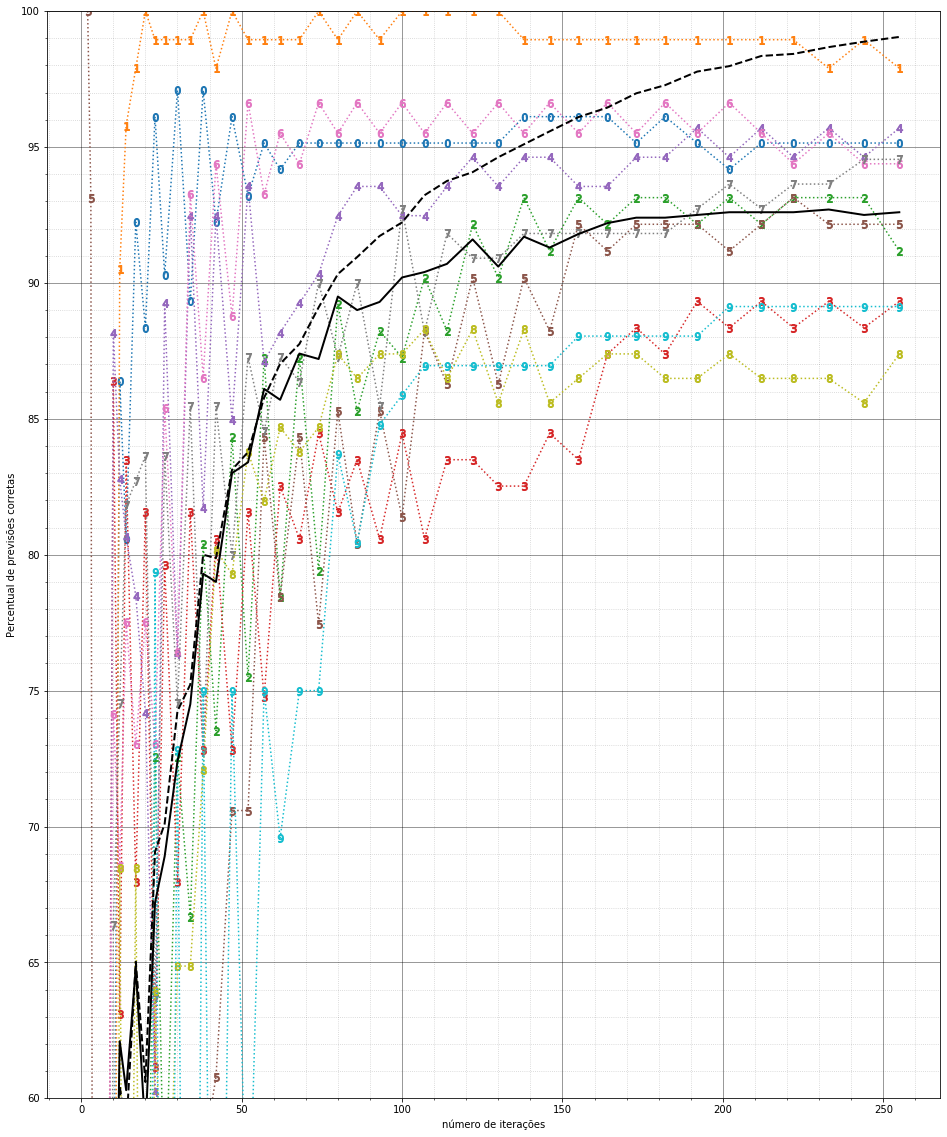

In [93]:

taxa_algs = [ [None] for i in range(10) ]
taxa_teste = []
taxa_treino =[]
for t in tetas:
    pqp = rede_neural(dados_MS960[:4000], [400, 25, 25, 10], 0)
    pqp.pesos_iniciais = t
    pqp.As = pqp.embrulha(t)[0]
    pqp.bs = pqp.embrulha(t)[1]
    taxa_teste.append(performance_rede(pqp, dados_MS960[4000:])[0])
    taxa_treino.append(performance_rede(pqp, dados_MS960[:4000])[0])
    for i in range(10):
        taxa_algs[i].append(100 - performance_rede(pqp, dados_MS960[4000:])[1][i])
        
plt.figure(figsize=(16,20))
for (i, a) in enumerate(taxa_algs):
    mark = '$'+str(i)+'$'
    plt.plot(it, a, ':', marker=mark, markersize = 8)
plt.plot(it[1:], taxa_teste, 'k-', linewidth=2)
plt.plot(it[1:], taxa_treino, 'k--', linewidth=2)
plt.ylim(60, 100)
plt.xlabel('número de iterações')
plt.ylabel('Percentual de previsões corretas')
plt.grid(b=True, which='major', color='k', linestyle='-', alpha=.5)
plt.grid(b=True, which='minor', color='k', linestyle=':', alpha=0.2)
plt.minorticks_on()
plt.savefig('rede_dupla.png')
plt.show()

percentual de acerto:  10.2
percentual de erro de cada algarismo:  [100. 100. 100. 100. 100.   0. 100. 100. 100. 100.]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  9.950000000000001
percentual de erro de cada algarismo:  [100. 100. 100. 100. 100.   0. 100. 100. 100. 100.]
distribuicao de cada algarismo no espaço:  [ 9.925 10.125  9.95   9.925 10.175  9.95  10.275  9.75   9.725 10.2  ]
percentual de acerto:  10.2
percentual de erro de cada algarismo:  [100. 100. 100. 100. 100.   0. 100. 100. 100. 100.]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  10.2
percentual de erro de cada algarismo:  [100. 100. 100. 100. 100.   0. 100. 100. 100. 100.]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  10.2
percentual de erro de cada algarismo:  [100. 100. 100. 100. 100.   0. 100. 100. 100

percentual de acerto:  5.4
percentual de erro de cada algarismo:  [100.         100.         100.          86.40776699  98.92473118
  95.09803922  76.40449438  98.18181818  90.09009009 100.        ]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  5.4
percentual de erro de cada algarismo:  [100.         100.         100.          86.40776699  98.92473118
  95.09803922  76.40449438  98.18181818  90.09009009 100.        ]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  5.4
percentual de erro de cada algarismo:  [100.         100.         100.          86.40776699  98.92473118
  95.09803922  76.40449438  98.18181818  90.09009009 100.        ]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  6.4
percentual de erro de cada algarismo:  [100.         100.         100.          88.34951456

percentual de acerto:  13.5
percentual de erro de cada algarismo:  [100.          95.78947368 100.          60.19417476  68.8172043
  99.01960784  51.68539326  95.45454545  92.79279279  95.65217391]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  13.5
percentual de erro de cada algarismo:  [100.          95.78947368 100.          60.19417476  68.8172043
  99.01960784  51.68539326  95.45454545  92.79279279  95.65217391]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  13.5
percentual de erro de cada algarismo:  [100.          95.78947368 100.          60.19417476  68.8172043
  99.01960784  51.68539326  95.45454545  92.79279279  95.65217391]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  13.5
percentual de erro de cada algarismo:  [100.          95.78947368 100.          60.1941747

percentual de acerto:  58.8
percentual de erro de cada algarismo:  [26.44836272  9.13580247 52.7638191  11.83879093 30.95823096 82.66331658
 13.13868613 22.05128205 75.83547558 87.99019608]
distribuicao de cada algarismo no espaço:  [ 9.925 10.125  9.95   9.925 10.175  9.95  10.275  9.75   9.725 10.2  ]
percentual de acerto:  60.3
percentual de erro de cada algarismo:  [19.41747573  4.21052632 55.88235294 16.50485437 19.35483871 87.25490196
 22.47191011 18.18181818 71.17117117 79.34782609]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  60.3
percentual de erro de cada algarismo:  [19.41747573  4.21052632 55.88235294 16.50485437 19.35483871 87.25490196
 22.47191011 18.18181818 71.17117117 79.34782609]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  60.3
percentual de erro de cada algarismo:  [19.41747573  4.21052632 55.88235294 16.50485437 19.354838

percentual de acerto:  58.699999999999996
percentual de erro de cada algarismo:  [11.65048544  0.         53.92156863 18.44660194 25.80645161 85.29411765
 22.47191011 16.36363636 79.27927928 97.82608696]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  58.699999999999996
percentual de erro de cada algarismo:  [11.65048544  0.         53.92156863 18.44660194 25.80645161 85.29411765
 22.47191011 16.36363636 79.27927928 97.82608696]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  58.699999999999996
percentual de erro de cada algarismo:  [11.65048544  0.         53.92156863 18.44660194 25.80645161 85.29411765
 22.47191011 16.36363636 79.27927928 97.82608696]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  58.699999999999996
percentual de erro de cada algarismo:  [11.65048544  0.      

percentual de acerto:  74.25
percentual de erro de cada algarismo:  [ 4.28211587  3.20987654 21.35678392 25.44080605 33.90663391 69.59798995
 14.35523114 21.02564103 35.47557841 29.41176471]
distribuicao de cada algarismo no espaço:  [ 9.925 10.125  9.95   9.925 10.175  9.95  10.275  9.75   9.725 10.2  ]
percentual de acerto:  72.39999999999999
percentual de erro de cada algarismo:  [ 2.91262136  1.05263158 27.45098039 32.03883495 23.65591398 74.50980392
 23.59550562 25.45454545 35.13513514 27.17391304]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  72.39999999999999
percentual de erro de cada algarismo:  [ 2.91262136  1.05263158 27.45098039 32.03883495 23.65591398 74.50980392
 23.59550562 25.45454545 35.13513514 27.17391304]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  72.39999999999999
percentual de erro de cada algarismo:  [ 2.91262136  1.05

percentual de acerto:  79.875
percentual de erro de cada algarismo:  [ 9.31989924  4.19753086 22.61306533 14.35768262 12.53071253 36.93467337
  4.13625304 11.02564103 23.3933162  62.5       ]
distribuicao de cada algarismo no espaço:  [ 9.925 10.125  9.95   9.925 10.175  9.95  10.275  9.75   9.725 10.2  ]
percentual de acerto:  79.0
percentual de erro de cada algarismo:  [ 7.76699029  2.10526316 26.47058824 19.41747573  7.52688172 39.21568627
  5.61797753 14.54545455 19.81981982 68.47826087]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  79.0
percentual de erro de cada algarismo:  [ 7.76699029  2.10526316 26.47058824 19.41747573  7.52688172 39.21568627
  5.61797753 14.54545455 19.81981982 68.47826087]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  79.0
percentual de erro de cada algarismo:  [ 7.76699029  2.10526316 26.47058824 19.41747573  7.5268

percentual de acerto:  83.39999999999999
percentual de erro de cada algarismo:  [ 6.7961165   1.05263158 24.50980392 18.44660194  6.4516129  29.41176471
  3.37078652 12.72727273 16.21621622 46.73913043]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  83.39999999999999
percentual de erro de cada algarismo:  [ 6.7961165   1.05263158 24.50980392 18.44660194  6.4516129  29.41176471
  3.37078652 12.72727273 16.21621622 46.73913043]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  83.39999999999999
percentual de erro de cada algarismo:  [ 6.7961165   1.05263158 24.50980392 18.44660194  6.4516129  29.41176471
  3.37078652 12.72727273 16.21621622 46.73913043]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  86.1
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158 12.74509804 25

percentual de acerto:  87.4
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158 12.74509804 19.41747573 10.75268817 15.68627451
  5.61797753 13.63636364 16.21621622 25.        ]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  87.4
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158 12.74509804 19.41747573 10.75268817 15.68627451
  5.61797753 13.63636364 16.21621622 25.        ]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  87.4
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158 12.74509804 19.41747573 10.75268817 15.68627451
  5.61797753 13.63636364 16.21621622 25.        ]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  87.4
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158 12.74509804 19.41747573 10.75268817 15.68627451
  5.6

percentual de acerto:  89.0
percentual de erro de cada algarismo:  [ 4.85436893  0.         14.70588235 16.50485437  6.4516129  19.60784314
  3.37078652 10.         13.51351351 19.56521739]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  89.0
percentual de erro de cada algarismo:  [ 4.85436893  0.         14.70588235 16.50485437  6.4516129  19.60784314
  3.37078652 10.         13.51351351 19.56521739]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  89.0
percentual de erro de cada algarismo:  [ 4.85436893  0.         14.70588235 16.50485437  6.4516129  19.60784314
  3.37078652 10.         13.51351351 19.56521739]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  89.0
percentual de erro de cada algarismo:  [ 4.85436893  0.         14.70588235 16.50485437  6.4516129  19.60784314
  3.3

percentual de acerto:  90.2
percentual de erro de cada algarismo:  [ 4.85436893  0.         12.74509804 15.53398058  7.52688172 18.62745098
  3.37078652  7.27272727 12.61261261 14.13043478]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  90.2
percentual de erro de cada algarismo:  [ 4.85436893  0.         12.74509804 15.53398058  7.52688172 18.62745098
  3.37078652  7.27272727 12.61261261 14.13043478]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  90.2
percentual de erro de cada algarismo:  [ 4.85436893  0.         12.74509804 15.53398058  7.52688172 18.62745098
  3.37078652  7.27272727 12.61261261 14.13043478]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  90.2
percentual de erro de cada algarismo:  [ 4.85436893  0.         12.74509804 15.53398058  7.52688172 18.62745098
  3.3

percentual de acerto:  91.60000000000001
percentual de erro de cada algarismo:  [ 4.85436893  0.          7.84313725 16.50485437  5.37634409  9.80392157
  4.49438202  9.09090909 11.71171171 13.04347826]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  91.60000000000001
percentual de erro de cada algarismo:  [ 4.85436893  0.          7.84313725 16.50485437  5.37634409  9.80392157
  4.49438202  9.09090909 11.71171171 13.04347826]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  91.60000000000001
percentual de erro de cada algarismo:  [ 4.85436893  0.          7.84313725 16.50485437  5.37634409  9.80392157
  4.49438202  9.09090909 11.71171171 13.04347826]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  91.60000000000001
percentual de erro de cada algarismo:  [ 4.85436893  0.          

percentual de acerto:  91.3
percentual de erro de cada algarismo:  [ 3.88349515  1.05263158  8.82352941 15.53398058  5.37634409 11.76470588
  3.37078652  8.18181818 14.41441441 13.04347826]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  91.3
percentual de erro de cada algarismo:  [ 3.88349515  1.05263158  8.82352941 15.53398058  5.37634409 11.76470588
  3.37078652  8.18181818 14.41441441 13.04347826]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  91.3
percentual de erro de cada algarismo:  [ 3.88349515  1.05263158  8.82352941 15.53398058  5.37634409 11.76470588
  3.37078652  8.18181818 14.41441441 13.04347826]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  91.3
percentual de erro de cada algarismo:  [ 3.88349515  1.05263158  8.82352941 15.53398058  5.37634409 11.76470588
  3.3

percentual de acerto:  92.2
percentual de erro de cada algarismo:  [ 3.88349515  1.05263158  7.84313725 12.62135922  6.4516129   8.82352941
  3.37078652  8.18181818 12.61261261 11.95652174]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  92.4
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158  6.8627451  11.65048544  5.37634409  7.84313725
  4.49438202  8.18181818 12.61261261 11.95652174]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  96.975
percentual de erro de cada algarismo:  [1.25944584 1.97530864 3.51758794 5.03778338 2.7027027  2.7638191
 1.94647202 3.33333333 3.59897172 4.16666667]
distribuicao de cada algarismo no espaço:  [ 9.925 10.125  9.95   9.925 10.175  9.95  10.275  9.75   9.725 10.2  ]
percentual de acerto:  92.4
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158  6.8627451  11.65048544  5.37634409  7.843

percentual de acerto:  92.5
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158  7.84313725 10.67961165  4.30107527  7.84313725
  4.49438202  7.27272727 13.51351351 11.95652174]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  92.5
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158  7.84313725 10.67961165  4.30107527  7.84313725
  4.49438202  7.27272727 13.51351351 11.95652174]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  92.5
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158  7.84313725 10.67961165  4.30107527  7.84313725
  4.49438202  7.27272727 13.51351351 11.95652174]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  92.5
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158  7.84313725 10.67961165  4.30107527  7.84313725
  4.4

percentual de acerto:  92.60000000000001
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158  6.8627451  11.65048544  5.37634409  6.8627451
  5.61797753  6.36363636 13.51351351 10.86956522]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  98.425
percentual de erro de cada algarismo:  [0.75566751 0.74074074 1.50753769 2.51889169 2.21130221 1.50753769
 0.486618   1.79487179 1.28534704 2.94117647]
distribuicao de cada algarismo no espaço:  [ 9.925 10.125  9.95   9.925 10.175  9.95  10.275  9.75   9.725 10.2  ]
percentual de acerto:  92.60000000000001
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158  6.8627451  11.65048544  5.37634409  6.8627451
  5.61797753  6.36363636 13.51351351 10.86956522]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  92.60000000000001
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158  6.8

percentual de acerto:  92.5
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158  6.8627451  11.65048544  5.37634409  7.84313725
  5.61797753  5.45454545 14.41441441 10.86956522]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  92.5
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158  6.8627451  11.65048544  5.37634409  7.84313725
  5.61797753  5.45454545 14.41441441 10.86956522]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  92.5
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158  6.8627451  11.65048544  5.37634409  7.84313725
  5.61797753  5.45454545 14.41441441 10.86956522]
distribuicao de cada algarismo no espaço:  [10.3  9.5 10.2 10.3  9.3 10.2  8.9 11.  11.1  9.2]
percentual de acerto:  92.5
percentual de erro de cada algarismo:  [ 4.85436893  1.05263158  6.8627451  11.65048544  5.37634409  7.84313725
  5.6

ValueError: x and y must have same first dimension, but have shapes (45,) and (44,)

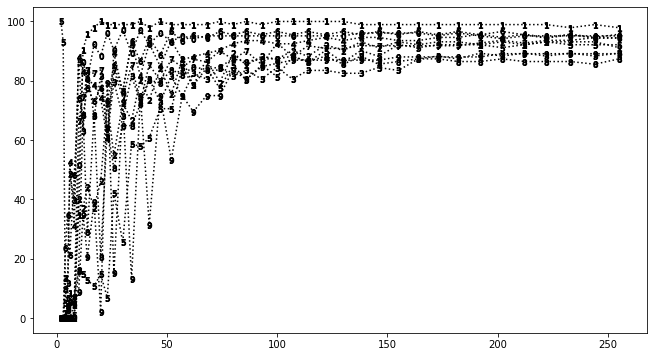

In [67]:

taxa_algs = [ [None] for i in range(10) ]
taxa_teste = []
taxa_treino =[]
for t in tetas:
    pqp = rede_neural(dados_MS960[:4000], [400, 25, 25, 10], 0)
    pqp.pesos_iniciais = t
    pqp.As = pqp.embrulha(t)[0]
    pqp.bs = pqp.embrulha(t)[1]
    taxa_teste.append(performance_rede(pqp, dados_MS960[4000:])[0])
    taxa_treino.append(performance_rede(pqp, dados_MS960[:4000])[0])
    for i in range(10):
        taxa_algs[i].append(100 - performance_rede(pqp, dados_MS960[4000:])[1][i])
        
plt.figure(figsize=(11,6))
for (i, a) in enumerate(taxa_algs):
    mark = '$'+str(i)+'$'
    plt.plot(it, a, 'k:', marker=mark)
plt.plot(it, taxa_teste, 'k-')
plt.plot(it, taxa_treino, 'k--')
plt.grid(b=True, which='major', color='k', linestyle='-', alpha=.5)
plt.grid(b=True, which='minor', color='k', linestyle=':', alpha=0.2)
plt.minorticks_on()
plt.savefig('converg_treino.png')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (45,) and (44,)

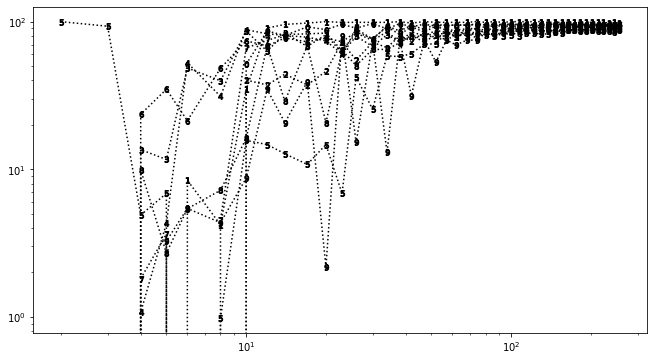

In [68]:
plt.figure(figsize=(11,6))
for (i, a) in enumerate(taxa_algs):
    mark = '$'+str(i)+'$'
    plt.loglog(it, a, 'k:', marker=mark)
plt.loglog(it, taxa_teste, 'k-')
plt.loglog(it, taxa_treino, 'k--')
plt.grid(b=True, which='major', color='k', linestyle='-', alpha=.5)
plt.grid(b=True, which='minor', color='k', linestyle=':', alpha=0.2)
plt.minorticks_on()
plt.savefig('converg_treino_loglog.png')
plt.show()

In [75]:
it

[1,
 2,
 3,
 4,
 5,
 6,
 8,
 10,
 12,
 14,
 17,
 20,
 23,
 26,
 30,
 34,
 38,
 42,
 47,
 52,
 57,
 62,
 68,
 74,
 80,
 86,
 93,
 100,
 107,
 114,
 122,
 130,
 138,
 146,
 155,
 164,
 173,
 182,
 192,
 202,
 212,
 222,
 233,
 244,
 255]

In [72]:
len(taxa_treino)

44

In [74]:
taxa_teste

[10.2,
 9.5,
 5.4,
 6.4,
 13.700000000000001,
 13.5,
 47.9,
 62.1,
 60.3,
 64.8,
 58.699999999999996,
 67.2,
 68.89999999999999,
 72.39999999999999,
 74.5,
 79.3,
 79.0,
 83.0,
 83.39999999999999,
 86.1,
 85.7,
 87.4,
 87.2,
 89.5,
 89.0,
 89.3,
 90.2,
 90.4,
 90.7,
 91.60000000000001,
 90.60000000000001,
 91.7,
 91.3,
 91.8,
 92.2,
 92.4,
 92.4,
 92.5,
 92.60000000000001,
 92.60000000000001,
 92.60000000000001,
 92.7,
 92.5,
 92.60000000000001]